In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import requests # Digunakan untuk mengambil data dari API (misalnya kurs)
import json # Digunakan untuk memproses data JSON dari API

In [8]:
# --- 1. Pengambilan Data ---
print("\n--- 1. Pengambilan Data ---")

# Mengunduh data historis Bitcoin (BTC-USD) dari Yahoo Finance.
df = yf.download('BTC-USD', start='2015-01-01', end='2025-06-24')

df.head()

/tmp/ipython-input-8-3735948355.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2015-01-01', end='2025-06-24')
[*********************100%***********************]  1 of 1 completed


--- 1. Pengambilan Data ---


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


In [9]:
# --- 2. Pra-pemrosesan Data ---
print("\n--- 2. Pra-pemrosesan Data ---")
data = df[['Close']].values
print(f"Bentuk data harga penutupan sebelum normalisasi: {data.shape}")


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(f"Bentuk data harga setelah normalisasi: {scaled_data.shape}")
print("Data harga berhasil dinormalisasi ke rentang [0, 1].")

def create_multistep_sequences(data, input_window=60, output_window=7):
    X, y = [], []
    for i in range(len(data) - input_window - output_window):
        X.append(data[i:(i + input_window), 0])
        y.append(data[(i + input_window):(i + input_window + output_window), 0])
    return np.array(X), np.array(y)


--- 2. Pra-pemrosesan Data ---
Bentuk data harga penutupan sebelum normalisasi: (3827, 1)
Bentuk data harga setelah normalisasi: (3827, 1)
Data harga berhasil dinormalisasi ke rentang [0, 1].


In [11]:
INPUT_WINDOW = 60 # 60 hari historis sebagai input untuk prediksi.
OUTPUT_WINDOW = 7 # 7 hari ke depan sebagai target prediksi.

X, y = create_multistep_sequences(scaled_data, INPUT_WINDOW, OUTPUT_WINDOW)

print(f"Bentuk urutan input (X) setelah pembuatan sequences: {X.shape}")
print(f"Bentuk urutan output (y) setelah pembuatan sequences: {y.shape}")
print("Urutan data multi-step berhasil dibuat.")

Bentuk urutan input (X) setelah pembuatan sequences: (3760, 60)
Bentuk urutan output (y) setelah pembuatan sequences: (3760, 7)
Urutan data multi-step berhasil dibuat.


In [12]:
# Membagi data yang sudah di-sequence menjadi set pelatihan dan pengujian.
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Jumlah sampel pelatihan (X_train): {X_train.shape[0]}")
print(f"Jumlah sampel pengujian (X_test): {X_test.shape[0]}")
print("Data berhasil dibagi menjadi set pelatihan dan pengujian.")

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Menampilkan bentuk akhir X_train dan X_test setelah reshape.
print(f"Bentuk X_train setelah reshape untuk LSTM: {X_train.shape}")
print(f"Bentuk X_test setelah reshape untuk LSTM: {X_test.shape}")
print("Data input berhasil di-reshape untuk model LSTM.")

Jumlah sampel pelatihan (X_train): 3008
Jumlah sampel pengujian (X_test): 752
Data berhasil dibagi menjadi set pelatihan dan pengujian.
Bentuk X_train setelah reshape untuk LSTM: (3008, 60, 1)
Bentuk X_test setelah reshape untuk LSTM: (752, 60, 1)
Data input berhasil di-reshape untuk model LSTM.


In [13]:
# --- 3. Pembangunan dan Pelatihan Model LSTM ---
print("\n--- 3. Pembangunan dan Pelatihan Model LSTM ---")

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(OUTPUT_WINDOW))

model.compile(optimizer='adam', loss='mse')

print("Ringkasan Model LSTM:")
model.summary()

print("\nMemulai pelatihan model...")
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)
print("Pelatihan model selesai.")


--- 3. Pembangunan dan Pelatihan Model LSTM ---
Ringkasan Model LSTM:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,351 (67.78 KB)

 Trainable params: 17,351 (67.78 KB)

 Non-trainable params: 0 (0.00 B)


Memulai pelatihan model...
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0152 - val_loss: 2.7897e-04
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.1798e-04 - val_loss: 2.5449e-04
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.3178e-04 - val_loss: 6.8062e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 5.0162e-04 - val_loss: 2.6985e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.5482e-04 - val_loss: 2.2268e-04
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.5471e-04 - val_loss: 2.1398e-04
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.2755e-04 - val_loss: 4.5040e-04
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.0782e-04 - val_loss: 2.2527e-04
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.9487e-04 - val_loss: 2.0890e-04
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.2172e-04 - val_loss: 2.0110e-04
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32m

In [16]:
# Import fungsi metrik yang diperlukan dari scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np # Pastikan numpy juga diimpor untuk np.sqrt

# --- 4. Evaluasi Model ---
print("\n--- 4. Evaluasi Model ---")

# Menghitung metrik evaluasi kinerja model.
# Kode di bawah ini sekarang akan berjalan dengan benar
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")



--- 4. Evaluasi Model ---
Mean Squared Error (MSE): 41867102.94
Root Mean Squared Error (RMSE): 6470.48
Mean Absolute Error (MAE): 4525.93



--- 5. Visualisasi Hasil Prediksi ---


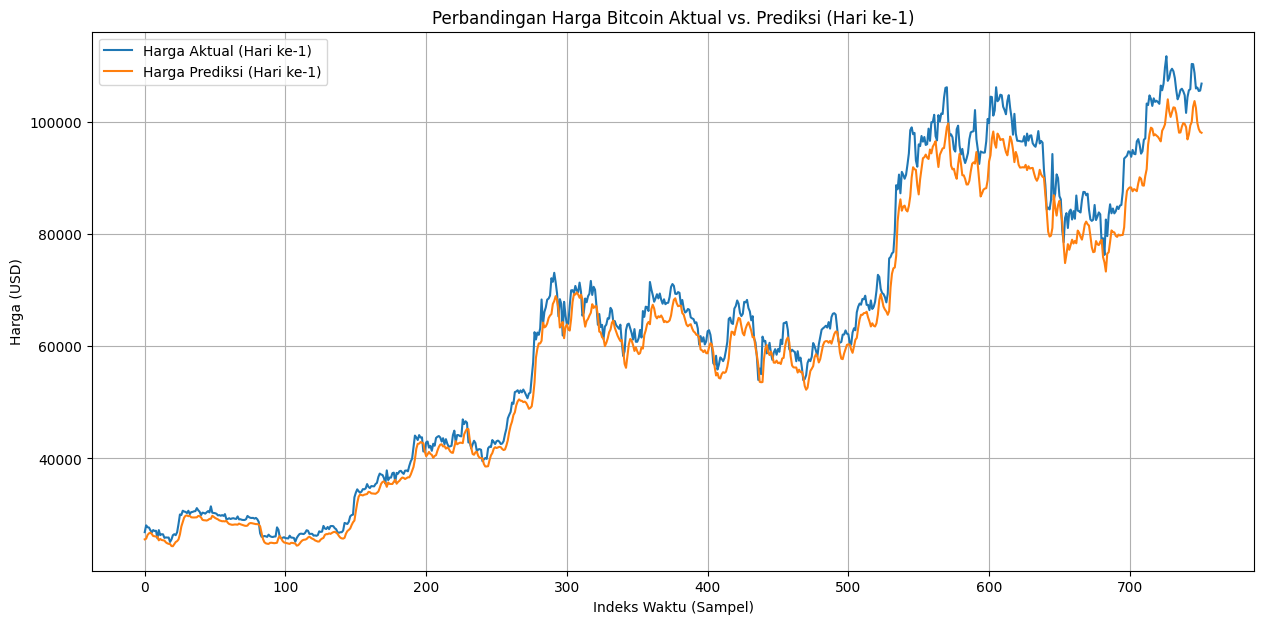

Visualisasi perbandingan harga aktual vs. prediksi selesai.


In [17]:
# --- 5. Visualisasi Hasil Prediksi ---
print("\n--- 5. Visualisasi Hasil Prediksi ---")

plt.figure(figsize=(15, 7))
plt.plot(y_test_rescaled[:, 0], label='Harga Aktual (Hari ke-1)')
plt.plot(predictions_rescaled[:, 0], label='Harga Prediksi (Hari ke-1)')
plt.title('Perbandingan Harga Bitcoin Aktual vs. Prediksi (Hari ke-1)')
plt.xlabel('Indeks Waktu (Sampel)')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True)
plt.show()
print("Visualisasi perbandingan harga aktual vs. prediksi selesai.")

In [18]:
# --- 6. Prediksi Harga Bitcoin 7 Hari ke Depan ---
print("\n--- 6. Prediksi Harga Bitcoin 7 Hari ke Depan ---")

# Mengambil 60 hari terakhir dari data yang sudah dinormalisasi.
last_sequence = scaled_data[-INPUT_WINDOW:].reshape(1, INPUT_WINDOW, 1)

# Membuat prediksi 7 hari ke depan menggunakan model.
future_prediction_scaled = model.predict(last_sequence, verbose=0)

future_prices_usd = scaler.inverse_transform(future_prediction_scaled).flatten()

print("Prediksi harga Bitcoin untuk 7 hari ke depan (USD):")
for i, price in enumerate(future_prices_usd):
    print(f"Hari ke-{i+1}: ${price:,.2f}")

# Mengambil kurs USD ke IDR dari API eksternal.
print("\nMengambil kurs USD ke IDR...")
try:
    url = 'https://api.frankfurter.app/latest?from=USD&to=IDR'
    response = requests.get(url)
    response.raise_for_status()
    data_exchange = response.json() # Mengurai respons JSON
    usd_to_idr_rate = data_exchange['rates']['IDR'] # Mengambil kurs IDR
    print(f"Kurs USD ke IDR saat ini: Rp {usd_to_idr_rate:,.2f}")
except requests.exceptions.RequestException as e:
    print(f"Error saat mengambil kurs: {e}. Menggunakan kurs default 1 USD = 15,000 IDR.")
    usd_to_idr_rate = 15000

# Mengonversi prediksi harga dari USD ke IDR.
future_prices_idr = future_prices_usd * usd_to_idr_rate

print("\nPrediksi harga Bitcoin untuk 7 hari ke depan (IDR):")
for i, price in enumerate(future_prices_idr):
    print(f"Hari ke-{i+1}: Rp {price:,.2f}")

print("\n--- Proses selesai ---")


--- 6. Prediksi Harga Bitcoin 7 Hari ke Depan ---
Prediksi harga Bitcoin untuk 7 hari ke depan (USD):
Hari ke-1: $97,829.73
Hari ke-2: $95,998.07
Hari ke-3: $94,537.14
Hari ke-4: $90,218.44
Hari ke-5: $92,498.07
Hari ke-6: $89,208.79
Hari ke-7: $87,455.48

Mengambil kurs USD ke IDR...
Kurs USD ke IDR saat ini: Rp 16,324.00

Prediksi harga Bitcoin untuk 7 hari ke depan (IDR):
Hari ke-1: Rp 1,596,972,544.00
Hari ke-2: Rp 1,567,072,512.00
Hari ke-3: Rp 1,543,224,320.00
Hari ke-4: Rp 1,472,725,760.00
Hari ke-5: Rp 1,509,938,560.00
Hari ke-6: Rp 1,456,244,224.00
Hari ke-7: Rp 1,427,623,296.00

--- Proses selesai ---
